## Introduction

If you are an investor in stocks or bonds you are probably always looking for ways to increase your return or lower your risk, and it turns out there is a way to do both simultaneously called rebalancing. Portfolio rebalancing is something every investor should either do themselves or have done for them. Registered investment advisors like Vanguard and others will provide this service as part of an active management agreement, while robo-advisors such as Betterment will also rebalance automatically. To understand why its so important, I'll defer to the finance professionals over at [BogleHeads](https://www.bogleheads.org/wiki/Rebalancing) :

>Rebalancing is the action of bringing a portfolio that has deviated away from one's target asset allocation back into line. The objective is to maintain a consistent mix of asset classes (most commonly equities vs. fixed income) in order to control risk at the level desired by the investor. This is accomplished by transferring funds from higher-performing classes to lower-performing classes. While potentially counterintuitive, rebalancing ensures that investors "Buy Low" and "Sell High".

Much research has been conducted on the benefits of portoflio rebalancing, here is an excerpt from a fairly recent [Morgan Stanley](https://www.morganstanley.com/articles/rebalancing-effect) research piece:

>A disciplined approach to rebalancing portfolios annually can create additional return and lower volatility versus never rebalancing or rebalancing during different time periods. While investing for the long term requires patience, a disciplined approach to rebalancing can help create value beyond the cyclical trends of the market.

Timely and consistent rebalancing is a cornerstone of modern portfolio theory. Rebalancing can magnify returns by promoting selling high and buying low, and reduce long-term risk by ensuring the portfolio adheres to its designated risk tolerance. The keys are to rebalance in a timely manner (i.e. annually) and to do it consistently because the benefits of rebalancing compound over time - but rebalancing by hand is a pain, and that can lead to inconsistency. I pursued this project due to the lack of free tools to simply rebalance an existing portfolio. Sure, we can all use a worksheet to do the math each time, but why not automate it and make it more likely we will actually do it? Here, inspired by the work of [kdboller](https://nbviewer.jupyter.org/github/kdboller/pythonsp500/blob/a7066d998ff046c3cc8b26ece3b0efdf00959d57/Investment%20Portfolio%20Python%20Notebook_03_2018_blog%20example.ipynb) I'll use Pandas, the Tiingo API, and some simple math to calculate how to optimally rebalance a portfolio given a target allocation. This is a simple, no-frills portfolio rebalancing exercise which does not factor in important considerations such as tax efficiency, transaction costs, or alternate approaches such as stock-out rebalances, or bond-floor settings. Future versions of this project may contemplate these extra factors.  


Steps:  
1. Set triggers to rebalance (time or threshold or both)
2. Define our current Portfolio (accounttype, time, ticker, shares, cost basis, price)  
3. Define our target allocation (ticker, allocation)  
4. Factor in any new money being invested  
5. Calculate initial transactions needed to hit target allocation  
6. Determine which transactions are valid based on rebalance triggers
7. Iteratively determine sells and buys required to get as close as possible to target allocation  


References:

[pythonsp500 by kdboller](https://nbviewer.jupyter.org/github/kdboller/pythonsp500/blob/a7066d998ff046c3cc8b26ece3b0efdf00959d57/Investment%20Portfolio%20Python%20Notebook_03_2018_blog%20example.ipynb)

[Portfolio Rebalancing by bogleheads wiki](https://www.bogleheads.org/wiki/Rebalancing)

## Code

In [1]:
#Lets import the necessary packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
import decimal
from pandas_datareader import data as pdr
from keys import tiingo_key
#define todays datetime
now = datetime.datetime.now()

In [2]:
#Settings
new_money_in = 10000
#Set our rebalance threshold
rebal_threshold = .05 #allowable allocation drift
rebal_timeframe = 180 #in days

In [3]:
#Define target and current allocations
#create our target allocation
columns_t = ['ticker','allocation_target']
positions_t = [['VTSAX',0.5652],
             ['VIGAX',0.0131],
             ['VSMAX',0.0066],
             ['VSEQX',0.0066],
             ['VWIGX',0.0507],
             ['VTRIX',0.0507],
             ['VTIAX',0.1521],
             ['VBTLX',0.035],
             ['VTABX',0.015],
             ['VGSLX',0.05],
             ['VNQI',0.01],
             ['VDE',0.03],
             ['GLD',0.015]]

#set our current portfolio
columns_c = ['accounttype','lastrebaldate','ticker','basisdate','costbasis','shares']
positions_c = [['TAXB','2018-11-16','VTSAX','2012-10-27',120.20,2],
             ['401K','2018-11-16','VIGAX','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VSMAX','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VSEQX','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VWIGX','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VTRIX','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VTIAX','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VBTLX','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VTABX','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VGSLX','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VNQI','2017-1-02',56.70,14.5],
             ['401K','2018-11-16','VDE','2017-1-02',56.70,14.5],
            ['401K','2018-11-16','AAPL','2017-1-02',56.70,14.5]]

In [4]:
#lookup table for account type abbreviations
accounttypes = {'TAXB':'Taxable Brokerage', '401K':'401k', 'RIRA':'Roth-IRA', 'TIRA':'Traditional-IRA'}

#initialize target portfolio
targetalloc = pd.DataFrame(columns = columns_t, data = positions_t)
total=decimal.Decimal(targetalloc.allocation_target.sum())
if round(total,4) != 1:
    print('Target Allocation not 100% : {}'.format(int(total)))

#initialize current portfolio
start_port = pd.DataFrame(columns = columns_c, data = positions_c)
start_port.lastrebaldate = pd.to_datetime(start_port.lastrebaldate)
start_port.basisdate = pd.to_datetime(start_port.basisdate)

#Define list of distinct tickers we care about
tickers = set(targetalloc.ticker.unique().tolist()+start_port.ticker.unique().tolist())

In [5]:
#Next we pull the latest prices from Tiingo (YahooFinance is buggy, and IEX does not contain mutual fund data)
#Tiingo limits for free API: 500 unique tickers ever, 500 requests/hr, 20,000 requests/day
#https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#tiingo
#Tiingo API key required: set 'tiingo_key' value in python file called 'keys.py' in same directory as this script
now = datetime.datetime.now()
yesterday = now - datetime.timedelta(3) #avoids weekends with no data - need better weekend detection
start = datetime.datetime(yesterday.year, yesterday.month, yesterday.day)
end = datetime.datetime(now.year, now.month, now.day)

bad_tickers = []
for i, t in enumerate(tickers):
    try:
        if i==0:
            ohlc = pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close
        else:
            ohlc = ohlc.append(pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close)
    except:
        bad_tickers.append(t)
        
#print(bad_tickers)
ohlc = ohlc.to_frame(name='close')

#drop our date index since its only the latest data
ohlc2=ohlc.reset_index(level=1, drop=True)

In [6]:
#concatenate target allocation and latest prices with our portfolio
start_port_c = pd.merge(start_port, targetalloc, on ='ticker', how ='outer')
final_port = pd.merge(start_port_c, ohlc2, left_on ='ticker', right_index = True, how = 'left')

#set target to zero for tickers held but not present in our target allocation, set initial basisdate and costbasis for new securities entering the portfolio
final_port.fillna(value = {'allocation_target':0.0,'shares':0.0,'basisdate':pd.to_datetime(now.strftime("%Y-%m-%d")),'costbasis':final_port.close},inplace = True)

#calculate holding values and current allocation
final_port['value'] = final_port.close * final_port.shares #calculate value as price x shares
final_port.loc[final_port.value.isna() & final_port.shares.isna(),['value']]=0.0 #for securities not currently held but in our target (and close price failed to return), establish zero value
final_port['allocation'] = final_port.value / final_port.value.sum()
final_port['correction'] = final_port.allocation_target - final_port.allocation

In [7]:
#factor in any new money entering the portfolio and determine necessary changes in value and shares
#this method rebalances and factors in new money simultaneously - there may be more efficient methods
total_val = final_port.value.sum()
final_port['new_money_in'] = new_money_in * final_port.allocation_target #Account for new money in
final_port['value_chg'] = (total_val * final_port.correction) + final_port.new_money_in
final_port['shares_chg'] = final_port.value_chg / final_port.close
final_port.loc[final_port.value_chg.isna() & final_port.shares > 0,['shares_chg']]=-final_port.shares #sell all shares of securities not in our target portfolio

#round off shares to whole numbers, except when we are fully exiting a position
final_port['shares_chg_round'] = final_port.shares_chg
final_port = final_port.astype({'shares_chg_round': int})
final_port['final_shares_chg'] = final_port.shares_chg
final_port.loc[final_port.shares_chg+final_port.shares!=0,['final_shares_chg']]=final_port.shares_chg_round*1.0
final_port.drop(['shares_chg_round'],axis=1,inplace=True)

#create timedelta int column
final_port['timedelta'] = (final_port.lastrebaldate - pd.to_datetime(now.strftime("%Y-%m-%d"))).dt.days
final_port.timedelta.fillna(0,inplace=True)

#define rebalance flags to determine if we must rebalance
final_port['rebal_flag_thresh'] = np.where((abs(final_port.correction)<=rebal_threshold) & (final_port.allocation > 0),0,1)
final_port['rebal_flag_time'] = np.where(final_port.timedelta >= rebal_timeframe,1,0)
final_port['rebal_flag'] = np.where(final_port.rebal_flag_thresh + final_port.rebal_flag_time >= 1,1,0)

#These rows do not meet our rebalance threshold or timeframe cutoff - so we should set their change values to 0
#The exception is if new_money_in must be considered, in which case we will still rebalance by investing the new money
final_port.loc[(final_port.rebal_flag==0) & (final_port.new_money_in==0), ['value_chg','shares_chg','final_shares_chg']] = 0

#Calculate initial new shares and values
final_port['new_shares'] = (final_port.shares + final_port.final_shares_chg)
final_port['new_value'] = final_port.new_shares * final_port.close #due to share rounding, there will be slight variance vs. portfolio starting value
final_port['new_value_chg'] = final_port.final_shares_chg * final_port.close

In [8]:
final_port

,accounttype,lastrebaldate,ticker,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in,value_chg,shares_chg,final_shares_chg,timedelta,rebal_flag_thresh,rebal_flag_time,rebal_flag,new_shares,new_value,new_value_chg
0,TAXB,2018-11-16,VTSAX,2012-10-27,120.20,2.0,0.5652,64.77,129.540,0.012571,0.552629,5652.0,11346.879912,175.187277,175.0,-31.0,1,0,1,177.0,11464.290,11334.75
1,401K,2018-11-16,VIGAX,2017-01-02,56.70,14.5,0.0131,71.94,1043.130,0.101225,-0.088125,131.0,-777.133714,-10.802526,-10.0,-31.0,1,0,1,4.5,323.730,-719.40
2,401K,2018-11-16,VSMAX,2017-01-02,56.70,14.5,0.0066,66.33,961.785,0.093331,-0.086731,66.0,-827.771604,-12.479596,-12.0,-31.0,1,0,1,2.5,165.825,-795.96
3,401K,2018-11-16,VSEQX,2017-01-02,56.70,14.5,0.0066,31.05,450.225,0.043690,-0.037090,66.0,-316.211604,-10.183949,-10.0,-31.0,0,0,0,4.5,139.725,-310.50
4,401K,2018-11-16,VWIGX,2017-01-02,56.70,14.5,0.0507,26.93,390.485,0.037893,0.012807,507.0,638.981542,23.727499,23.0,-31.0,0,0,0,37.5,1009.875,619.39
5,401K,2018-11-16,VTRIX,2017-01-02,56.70,14.5,0.0507,34.67,502.715,0.048783,0.001917,507.0,526.751542,15.193295,15.0,-31.0,0,0,0,29.5,1022.765,520.05
6,401K,2018-11-16,VTIAX,2017-01-02,56.70,14.5,0.1521,25.95,376.275,0.036514,0.115586,1521.0,2712.124626,104.513473,104.0,-31.0,1,0,1,118.5,3075.075,2698.80
7,401K,2018-11-16,VBTLX,2017-01-02,56.70,14.5,0.0350,10.36,150.220,0.014577,0.020423,350.0,560.457100,54.098176,54.0,-31.0,0,0,0,68.5,709.660,559.44
8,401K,2018-11-16,VTABX,2017-01-02,56.70,14.5,0.0150,22.02,319.290,0.030984,-0.015984,150.0,-14.714100,-0.668215,0.0,-31.0,0,0,0,14.5,319.290,0.00
9,401K,2018-11-16,VGSLX,2017-01-02,56.70,14.5,0.0500,112.96,1637.920,0.158943,-0.108943,500.0,-622.667000,-5.512279,-5.0,-31.0,1,0,1,9.5,1073.120,-564.80


In [9]:
#create a balance counter initially set to the value of new money in (since this is available to invest)
bal = new_money_in

#next we use a value-sorted portfolio to iteratively sell/buy to get our final execution strategy
for index, row in final_port.sort_values(by='new_value_chg',ascending=True).iterrows():
    bal-=row.new_value_chg
    if bal > 0:
        final_port.loc[index,'execution_value'] = row.new_value
        final_port.loc[index,'execution_shares_chg'] = row.final_shares_chg
    else:
        final_port.loc[index,'execution_value'] = row.new_value + bal
        final_port.loc[index,'execution_shares_chg'] = int((row.new_value + bal)/row.close)
    print('Evaluating {} {}, new bal is {}'.format(row.ticker,row.new_value_chg,bal))

#calculate final values for execution
final_port['execution_value_chg'] = final_port.execution_shares_chg * final_port.close
final_port['execution_shares'] = final_port.execution_shares_chg + final_port.shares
final_port['execution_allocation'] = final_port.execution_value / final_port.execution_value.sum()

#double check our work - the final portfolio should be well within the rebalance threshold we defined
if len(final_port[(final_port.execution_allocation - final_port.allocation_target) > rebal_threshold]) > 0:
    print('ERROR: Target Portfolio not achieved')
else:
    print('Allocation Success!')

Evaluating AAPL -2377.13, new bal is 12377.130000000001
Evaluating VSMAX -795.96, new bal is 13173.09
Evaluating VIGAX -719.4, new bal is 13892.49
Evaluating VDE -570.15, new bal is 14462.64
Evaluating VGSLX -564.8, new bal is 15027.439999999999
Evaluating VNQI -541.5999999999999, new bal is 15569.039999999999
Evaluating VSEQX -310.5, new bal is 15879.539999999999
Evaluating VTABX 0.0, new bal is 15879.539999999999
Evaluating GLD 235.74, new bal is 15643.8
Evaluating VTRIX 520.0500000000001, new bal is 15123.75
Evaluating VBTLX 559.4399999999999, new bal is 14564.31
Evaluating VWIGX 619.39, new bal is 13944.92
Evaluating VTIAX 2698.7999999999997, new bal is 11246.12
Evaluating VTSAX 11334.75, new bal is -88.6299999999992
Allocation Success!


In [10]:
#Lets look at all our work to get to our target portfolio
final_port

,accounttype,lastrebaldate,ticker,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in,value_chg,shares_chg,final_shares_chg,timedelta,rebal_flag_thresh,rebal_flag_time,rebal_flag,new_shares,new_value,new_value_chg,execution_value,execution_shares_chg,execution_value_chg,execution_shares,execution_allocation
0,TAXB,2018-11-16,VTSAX,2012-10-27,120.20,2.0,0.5652,64.77,129.540,0.012571,0.552629,5652.0,11346.879912,175.187277,175.0,-31.0,1,0,1,177.0,11464.290,11334.75,11375.660,175.0,11334.75,177.0,0.560238
1,401K,2018-11-16,VIGAX,2017-01-02,56.70,14.5,0.0131,71.94,1043.130,0.101225,-0.088125,131.0,-777.133714,-10.802526,-10.0,-31.0,1,0,1,4.5,323.730,-719.40,323.730,-10.0,-719.40,4.5,0.015943
2,401K,2018-11-16,VSMAX,2017-01-02,56.70,14.5,0.0066,66.33,961.785,0.093331,-0.086731,66.0,-827.771604,-12.479596,-12.0,-31.0,1,0,1,2.5,165.825,-795.96,165.825,-12.0,-795.96,2.5,0.008167
3,401K,2018-11-16,VSEQX,2017-01-02,56.70,14.5,0.0066,31.05,450.225,0.043690,-0.037090,66.0,-316.211604,-10.183949,-10.0,-31.0,0,0,0,4.5,139.725,-310.50,139.725,-10.0,-310.50,4.5,0.006881
4,401K,2018-11-16,VWIGX,2017-01-02,56.70,14.5,0.0507,26.93,390.485,0.037893,0.012807,507.0,638.981542,23.727499,23.0,-31.0,0,0,0,37.5,1009.875,619.39,1009.875,23.0,619.39,37.5,0.049735
5,401K,2018-11-16,VTRIX,2017-01-02,56.70,14.5,0.0507,34.67,502.715,0.048783,0.001917,507.0,526.751542,15.193295,15.0,-31.0,0,0,0,29.5,1022.765,520.05,1022.765,15.0,520.05,29.5,0.050370
6,401K,2018-11-16,VTIAX,2017-01-02,56.70,14.5,0.1521,25.95,376.275,0.036514,0.115586,1521.0,2712.124626,104.513473,104.0,-31.0,1,0,1,118.5,3075.075,2698.80,3075.075,104.0,2698.80,118.5,0.151444
7,401K,2018-11-16,VBTLX,2017-01-02,56.70,14.5,0.0350,10.36,150.220,0.014577,0.020423,350.0,560.457100,54.098176,54.0,-31.0,0,0,0,68.5,709.660,559.44,709.660,54.0,559.44,68.5,0.034950
8,401K,2018-11-16,VTABX,2017-01-02,56.70,14.5,0.0150,22.02,319.290,0.030984,-0.015984,150.0,-14.714100,-0.668215,0.0,-31.0,0,0,0,14.5,319.290,0.00,319.290,0.0,0.00,14.5,0.015725
9,401K,2018-11-16,VGSLX,2017-01-02,56.70,14.5,0.0500,112.96,1637.920,0.158943,-0.108943,500.0,-622.667000,-5.512279,-5.0,-31.0,1,0,1,9.5,1073.120,-564.80,1073.120,-5.0,-564.80,9.5,0.052850


In [11]:
#Assemble our final output
display_port = final_port[['accounttype','lastrebaldate','ticker','costbasis','shares','close','allocation','allocation_target','execution_value_chg','execution_shares_chg','execution_shares','execution_value','execution_allocation']]

#To complete rebalancing investor should transact the shares in the 'execution_shares_chg' column in any order
display_port

,accounttype,lastrebaldate,ticker,costbasis,shares,close,allocation,allocation_target,execution_value_chg,execution_shares_chg,execution_shares,execution_value,execution_allocation
0,TAXB,2018-11-16,VTSAX,120.20,2.0,64.77,0.012571,0.5652,11334.75,175.0,177.0,11375.660,0.560238
1,401K,2018-11-16,VIGAX,56.70,14.5,71.94,0.101225,0.0131,-719.40,-10.0,4.5,323.730,0.015943
2,401K,2018-11-16,VSMAX,56.70,14.5,66.33,0.093331,0.0066,-795.96,-12.0,2.5,165.825,0.008167
3,401K,2018-11-16,VSEQX,56.70,14.5,31.05,0.043690,0.0066,-310.50,-10.0,4.5,139.725,0.006881
4,401K,2018-11-16,VWIGX,56.70,14.5,26.93,0.037893,0.0507,619.39,23.0,37.5,1009.875,0.049735
5,401K,2018-11-16,VTRIX,56.70,14.5,34.67,0.048783,0.0507,520.05,15.0,29.5,1022.765,0.050370
6,401K,2018-11-16,VTIAX,56.70,14.5,25.95,0.036514,0.1521,2698.80,104.0,118.5,3075.075,0.151444
7,401K,2018-11-16,VBTLX,56.70,14.5,10.36,0.014577,0.0350,559.44,54.0,68.5,709.660,0.034950
8,401K,2018-11-16,VTABX,56.70,14.5,22.02,0.030984,0.0150,0.00,0.0,14.5,319.290,0.015725
9,401K,2018-11-16,VGSLX,56.70,14.5,112.96,0.158943,0.0500,-564.80,-5.0,9.5,1073.120,0.052850


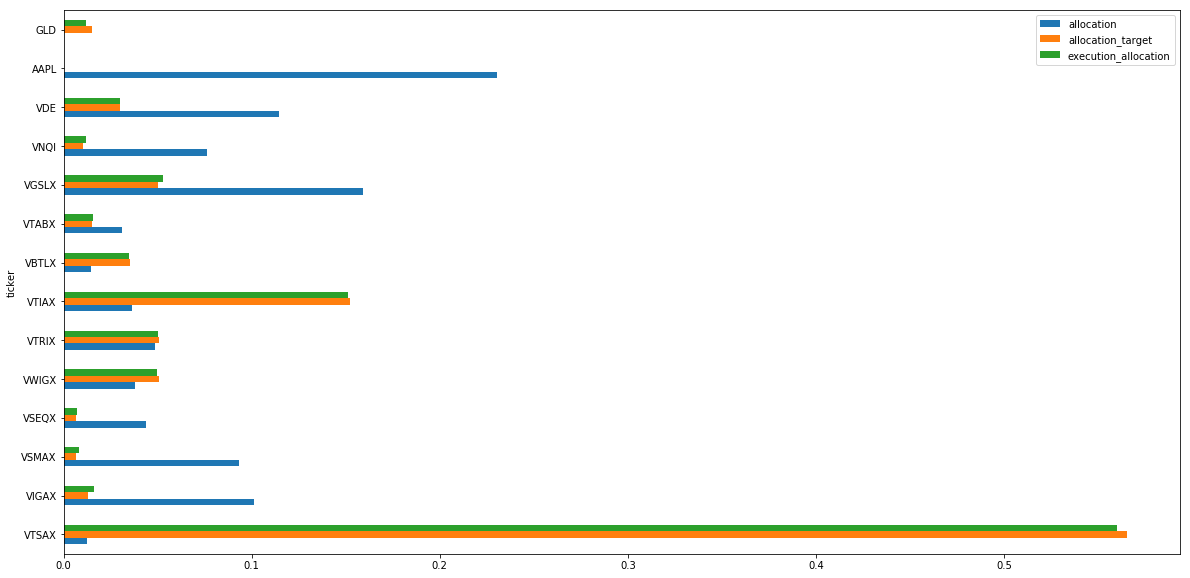

In [13]:
#Lets add a bar chart here to show the new allocation vs. the target allocation and vs. the original portfolio
graph_port = display_port[['ticker','allocation','allocation_target','execution_allocation']].copy()
graph_port.plot.barh(x='ticker',figsize=(20,10))

## Conclusion
Through this portfolio rebalancing demonstration using Pandas, you can see we have achieved a rebalanced portfolio very closely approximating our desired target allocation. Note how GLD was added as a new security, and AAPL was removed from the portfolio. The remaining securities were iteratively bought or sold as required by our target allocation. I accounted for whole-share rounding because most of the assets in this sample are index funds. This simple rebalancer can be adapted to your needs, and I urge you grab the code and see if you can improve upon it. I welcome your thoughts or feedback in the comments.